In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.stats import mode
import pandas as pd
import seaborn as sns
from io import StringIO
import requests
import json
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [2]:
df = pd.read_csv('Beehive Metrics Dataset/new_temp_2017.csv')
df.head()

,timestamp,min,max,mean
0,1/1/2017 5:00,-1.911244,4.505489,1.699496
1,1/1/2017 6:00,-3.370600,4.495117,1.092577
2,1/1/2017 7:00,-3.582800,4.276133,0.964174
3,1/1/2017 8:00,-3.881800,3.711483,0.824071
4,1/1/2017 9:00,-4.742200,3.108950,0.266976


In [3]:
#How many rows?
len(df.index)

104821

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104821 entries, 0 to 104820
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  104821 non-null  object 
 1   min        104821 non-null  float64
 2   max        104821 non-null  float64
 3   mean       104821 non-null  float64
dtypes: float64(3), object(1)
memory usage: 2.8+ MB


In [5]:
#Change the timestamp field to a datetime data type
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
#Print the info again to ensure that the data type was changed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104821 entries, 0 to 104820
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  104821 non-null  datetime64[ns]
 1   min        104821 non-null  float64       
 2   max        104821 non-null  float64       
 3   mean       104821 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.2 MB


In [7]:
#Show some data again to ensure that the timestamps didn't get messed up
df.head()

,timestamp,min,max,mean
0,2017-01-01 05:00:00,-1.911244,4.505489,1.699496
1,2017-01-01 06:00:00,-3.370600,4.495117,1.092577
2,2017-01-01 07:00:00,-3.582800,4.276133,0.964174
3,2017-01-01 08:00:00,-3.881800,3.711483,0.824071
4,2017-01-01 09:00:00,-4.742200,3.108950,0.266976


In [8]:
#Show mean, standard dev, min, max, and IQRs
df.describe()

,min,max,mean
count,104821.000000,104821.000000,104821.000000
mean,12.802953,25.886408,17.824496
std,8.472256,10.502566,9.016849
min,-10.072000,-0.740800,-5.983067
25%,6.006200,15.736000,9.939600
50%,12.606000,31.880000,19.113333
75%,19.520000,34.934000,25.272000
max,35.320000,57.362000,42.362667


In [9]:
#Count blanks or whitespaces
df = df.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
#Is anything null?
df.isnull().sum()

timestamp    0
min          0
max          0
mean         0
dtype: int64

In [10]:
#There are a few in this data set, let's see them
df[df.isna().any(axis=1)]

,timestamp,min,max,mean


In [11]:
#And remove them
df = df.dropna()
df.isnull().sum()

timestamp    0
min          0
max          0
mean         0
dtype: int64

In [12]:
#How many unique values?
for column in df:
    print(column, len(df[column].unique()))

timestamp 104821
min 21195
max 22634
mean 65074


array([[<AxesSubplot:title={'center':'timestamp'}>]], dtype=object)

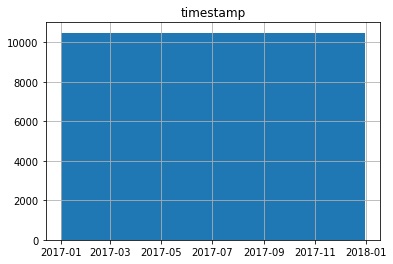

In [13]:
#Histogram of timestamps, seems like there's a big hole...
import matplotlib.pyplot as plt
%matplotlib inline
df.hist(column='timestamp')

array([[<AxesSubplot:title={'center':'mean'}>]], dtype=object)

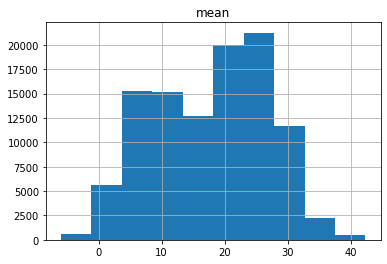

In [14]:
#And mean temperature...
df.hist(column='mean')

array([[<AxesSubplot:title={'center':'min'}>]], dtype=object)

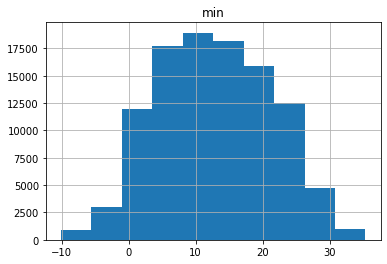

In [15]:
#min
df.hist(column='min')

array([[<AxesSubplot:title={'center':'max'}>]], dtype=object)

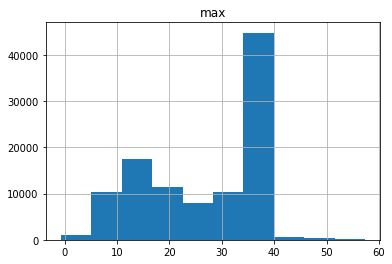

In [16]:
#max
df.hist(column='max')

In [17]:
#Check for and remove outliers in each column
for col in ['min', 'mean', 'max']:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    #print(col)
    #print(q1)
    #print(q3)
    #print(iqr)

    df.drop(df.loc[(df[col]<= (q1 - (1.5 * iqr))) | (df[col]>= (q3 + (1.5 * iqr)))].index, inplace = True)

array([[<AxesSubplot:title={'center':'mean'}>]], dtype=object)

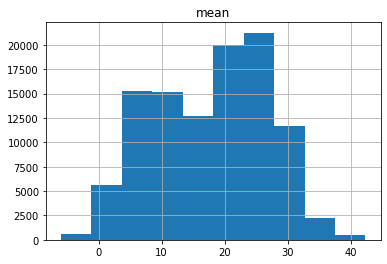

In [18]:
#Looks better!
df.hist(column='mean')

In [19]:
#Any duplicates?
df[df.duplicated()].sum()

min     0.0
max     0.0
mean    0.0
dtype: float64

In [20]:
#lOTS!
df[df.duplicated()]

,timestamp,min,max,mean


In [21]:
#So we have data values from what seem to be a number of different sensors at the same times, let's combine them
#into a min-max-avg for each timestamp

#timestamps = df['timestamp'].unique()
#newdf = pd.DataFrame(columns = ['timestamp', 'min', 'max', 'mean'])
#for datetime in timestamps:
#    #grab temperatures based on the unique timestamp
#    temps = df[df.timestamp == datetime]
#    mintmp = temps['temperature'].min()
#    maxtmp = temps['temperature'].max()
#    meantmp = temps['temperature'].mean()
    #append to the new dataframe
#    newdf = newdf.append({'timestamp': datetime, 'min': mintmp, 'max': maxtmp, 'mean': meantmp}, ignore_index = True)
    
#newdf.head()

In [22]:
#Save the new dataframe to a csv for later use
#newdf.to_csv('new_temp_2017.csv')
#newdf = pd.read_csv('Beehive Metrics Dataset/new_temp_2017.csv')

In [23]:
#Let's see some histograms of the new dataframe
#newdf.hist(column='mean')

In [24]:
#newdf.hist(column='min')
#newdf.hist(column='max')

In [25]:
#Show mean, standard dev, min, max, and IQRs after dropping rows
#newdf.describe()

In [26]:
#Get median, mode, variance
#print("median", df['temperature'].median())
#print("mode", mode(df['temperature']).mode[0])
#print("variance", df['temperature'].var())